In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.animation as animation
import os
import numpy as np

In [2]:
file_path = '/Users/Joyce Cai/calval/merged_dataset_smode_region_l4_20230328_20230711.nc'
ds_region = xr.open_dataset(file_path)

In [3]:
# Extract the variables for the region
adt = ds_region['adt']
ugos = ds_region['ugos']
vgos = ds_region['vgos']
lat = ds_region['latitude']
lon = ds_region['longitude']

In [326]:
from shapely.geometry import Polygon

# Define the latitude and longitude of the turning points
lat_lon_points = [
    (-122.9246513748008,37.00017075060504),
    (-123.3600045167993,37.75374578880221),
    (-124.0035685865631,37.70690473657844),
    (-125.4381962505588,38.11405549886727),
    (-126.2343691354205,38.33265671629315),
    (-125.4928752370857,35.61490575897531),
    (-124.1744291387648,36.00856716614078),
    (-124.3527449926306,36.34480115296711),
    (-122.9246513748008,37.00017075060504),
]

# Create the polygon
polygon = Polygon(lat_lon_points)

# Extract the exterior coordinates of the polygon
exterior_coords = polygon.exterior.coords.xy

## Calculate the inertia forcing term
### staring from time derivative du/dt, and move time step to the middle starting from now

In [306]:
dt = 1*24*60*60 # seconds of a day
du_dt = u.diff('time') / dt
dv_dt = v.diff('time') / dt

## the advection term

### convert lat and lon to m in order to get dx and dy

In [195]:
u = ugos
v = vgos

In [196]:
# Constants
R = 6371*1e3  # Earth's radius in meters

def lat_lon_to_m(lat, lon):
    # Calculate latitude and longitude spacing in degrees
    dlat = np.gradient(lat)
    dlon = np.gradient(lon)
    
    # Convert degrees to radians
    lat_rad = np.radians(lat)
    dlat_rad = np.radians(dlat)
    dlon_rad = np.radians(dlon)

    # Convert latitudinal and longitudinal differences to meters
    dlat_m = R * dlat_rad

    # Compute dlon_m for each latitude
    dlon_m = np.zeros((len(lat), len(lon)))
    for i in range(len(lat)):
        dlon_m[i, :] = R * np.cos(lat_rad[i]).values * dlon_rad
    
    return dlat_m, dlon_m

dlat_m_one, dlon_m = lat_lon_to_m(lat, lon)

In [198]:
# broadcast with the same shape of dlon_km (56,51)
dlat_m = dlat_m_one[:, np.newaxis] * np.ones(len(lon))

### calculate du and dv but 2d interpolate with dist. back to the grid center

In [ ]:
import numpy as np

# Earth's radius in meters
R = 6371000

# Convert to radians
lat_rad = np.radians(lat)
lon_rad = np.radians(lon)

# Initialize x and y grids
x_grid = np.zeros((len(lat_rad), len(lon_rad)))
y_grid = np.zeros((len(lat_rad), len(lon_rad)))

# Calculate x and y coordinates in meters
for i in range(len(lat_rad)):
    for j in range(len(lon_rad)):
        if j > 0:
            # Calculate x distance (along longitude) using true distance formula
            delta_lambda = lon_rad[j] - lon_rad[j-1]
            x_grid[i, j] = x_grid[i, j-1] + R * np.cos(lat_rad[i]) * delta_lambda
        if i > 0:
            # Calculate y distance (along latitude) using true distance formula
            delta_phi = lat_rad[i] - lat_rad[i-1]
            y_grid[i, j] = y_grid[i-1, j] + R * delta_phi

# Print shapes and example values
print(f"x_grid shape: {x_grid.shape}, y_grid shape: {y_grid.shape}")
print(f"x_grid example: {x_grid}")
print(f"y_grid example: {y_grid}")


### du/dx

In [289]:
# Calculate the differences in x_grid along the longitude direction
dx_grid = np.diff(x_grid, axis=1)  # Shape (lat, lon-1)

# Calculate the differences in u along the longitude direction
du = np.diff(u.data, axis=2)  # Shape (time, lat, lon-1)

# Compute the gradient (du/dx) along the longitude direction

du_dx = du / dx_grid[np.newaxis, :, :]  # Shape (time, lat, lon-1)

# For the last point, use backward difference (same as above)
du_dx_last = (u.data[:, :, -1] - u.data[:, :, -2]) / (x_grid[:, -1] - x_grid[:, -2])
du_dx = np.concatenate((du_dx, du_dx_last[..., np.newaxis]), axis=2)

# Print the gradient shape
print(f"du_dx shape: {du_dx.shape}")

du_dx shape: (106, 56, 51)


### dv/dx

In [293]:
# Calculate the differences in x_grid along the longitude direction
dx_grid = np.diff(x_grid, axis=1)  # Shape (lat, lon-1)

# Calculate the differences in u along the longitude direction
dv = np.diff(v.data, axis=2)  # Shape (time, lat, lon-1)

# Compute the gradient (du/dx) along the longitude direction

dv_dx = dv / dx_grid[np.newaxis, :, :]  # Shape (time, lat, lon-1)

# For the last point, use backward difference (same as above)
dv_dx_last = (v.data[:, :, -1] - v.data[:, :, -2]) / (x_grid[:, -1] - x_grid[:, -2])
dv_dx = np.concatenate((dv_dx, dv_dx_last[..., np.newaxis]), axis=2)

# Print the gradient shape
print(f"dv_dx shape: {dv_dx.shape}")

dv_dx shape: (106, 56, 51)


### du/dy

In [294]:
# Calculate the differences in y_grid along the latitude direction
dy_grid = np.diff(y_grid, axis=0)  # Shape (lat-1, lon)

# Calculate the differences in u along the longitude direction
du = np.diff(u.data, axis=1)  # Shape (time, lat-1, lon)

# Compute the gradient (du/dy) along the latitude direction

du_dy = du / dy_grid[np.newaxis, :, :]  # Shape (time, lat-1, lon)

# For the last point, use backward difference (same as above)
du_dy_last = (u.data[:, -1, :] - u.data[:, -2, :]) / (y_grid[-1,:] - y_grid[-2,:])
du_dy = np.concatenate((du_dy, du_dy_last[:, np.newaxis, :]), axis=1)

# Print the gradient shape
print(f"du_dy shape: {du_dy.shape}")

du_dy shape: (106, 56, 51)


### dv/dy

In [295]:
# Calculate the differences in y_grid along the latitude direction
dy_grid = np.diff(y_grid, axis=0)  # Shape (lat-1, lon)

# Calculate the differences in u along the longitude direction
dv = np.diff(v.data, axis=1)  # Shape (time, lat-1, lon)

# Compute the gradient (du/dy) along the latitude direction

dv_dy = dv / dy_grid[np.newaxis, :, :]  # Shape (time, lat-1, lon)

# For the last point, use backward difference (same as above)
dv_dy_last = (v.data[:, -1, :] - v.data[:, -2, :]) / (y_grid[-1,:] - y_grid[-2,:])
dv_dy = np.concatenate((dv_dy, dv_dy_last[:, np.newaxis, :]), axis=1)

# Print the gradient shape
print(f"dv_dy shape: {dv_dy.shape}")

dv_dy shape: (106, 56, 51)


In [296]:
# Compute nonlinear advection terms (ageostrophic components)
u_adv = u * du_dx + v * du_dy
v_adv = u * dv_dx + v * dv_dy

In [298]:
# Create rolling window with a window size of 2 along the 'time' dimension
u_adv_rolling = u_adv.rolling(time=2, center=False)
v_adv_rolling = v_adv.rolling(time=2, center=False)

# Calculate the mean over the rolling window
u_adv_avg = u_adv_rolling.mean()
v_adv_avg = v_adv_rolling.mean()

# Drop NaN values that may appear at the edges if you don't use center=True
u_adv_avg = u_adv_avg.dropna(dim='time', how='all')
v_adv_avg = v_adv_avg.dropna(dim='time', how='all')

## the inertial term would be

In [308]:
u_iner = du_dt + u_adv_avg
v_iner = dv_dt + v_adv_avg

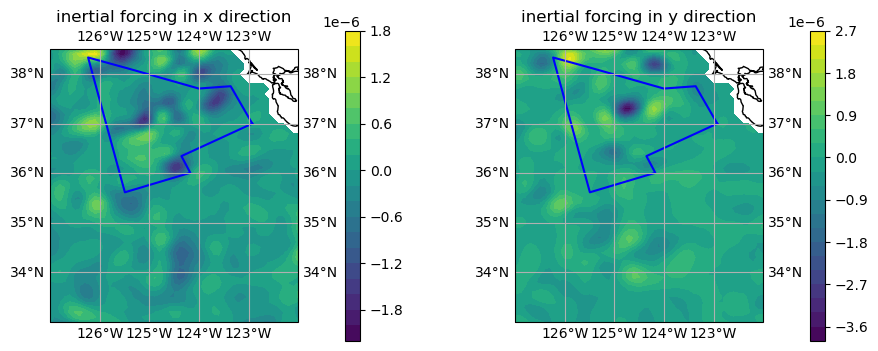

In [327]:
# Plotting the absolute difference using ccrs.PlateCarree()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()},
                              gridspec_kw={'wspace': 0.5}
                              )


# Adding coastlines and gridlines
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.gridlines(draw_labels=True)

# Plot the polygon
ax1.plot(exterior_coords[0], exterior_coords[1], 'b-', transform=ccrs.PlateCarree())

# Contour plot
cf = ax1.contourf(lon, lat, u_iner.isel(time=0), levels=21,
                  cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(cf, ax=ax1, orientation='vertical', label='', pad=0.15, fraction=0.05)

# Title and labels
ax1.set_title('inertial forcing in x direction')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')



# Adding coastlines and gridlines
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.gridlines(draw_labels=True)

# Plot the polygon
ax2.plot(exterior_coords[0], exterior_coords[1], 'b-', transform=ccrs.PlateCarree())

# Contour plot
cf2 = ax2.contourf(lon, lat, v_iner.isel(time=0), levels=21,
                 cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(cf2, ax=ax2, orientation='vertical', label='', pad=0.15, fraction=0.05)

# Title and labels
ax2.set_title('inertial forcing in y direction')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')


plt.show()

## Calculate the rotational forcing term

In [163]:
import numpy as np

def coriolis_frequency(latitude):
    """
    Calculate the Coriolis frequency (f) given a latitude.

    Parameters:
    latitude (float): Latitude in degrees.

    Returns:
    float: Coriolis frequency (f) in s^-1.
    """
    # Earth's angular velocity (rad/s)
    omega = 7.2921e-5
    # Convert latitude to radians
    latitude_rad = np.radians(latitude)
    # Calculate Coriolis frequency
    f = 2 * omega * np.sin(latitude_rad)
    return f

In [164]:
latitude = u['latitude']  # Latitude in degrees
f = coriolis_frequency(latitude)
v_rot = f*u

In [165]:
latitude = v['latitude']  # Latitude in degrees
f = coriolis_frequency(latitude)
u_rot = f*v

In [166]:
# Create rolling window with a window size of 2 along the 'time' dimension
u_rot_rolling = u_rot.rolling(time=2, center=False)
v_rot_rolling = v_rot.rolling(time=2, center=False)

# Calculate the mean over the rolling window
u_rot_avg = u_rot_rolling.mean()
v_rot_avg = v_rot_rolling.mean()

# Drop NaN values that may appear at the edges if you don't use center=True
u_rot_avg = u_rot_avg.dropna(dim='time', how='all')
v_rot_avg = v_rot_avg.dropna(dim='time', how='all')

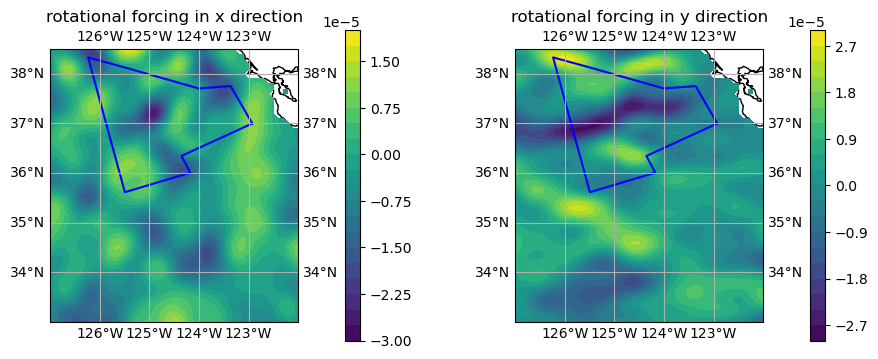

In [328]:
# Plotting the absolute difference using ccrs.PlateCarree()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()},
                              gridspec_kw={'wspace': 0.5}
                              )


# Adding coastlines and gridlines
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.gridlines(draw_labels=True)

# Plot the polygon
ax1.plot(exterior_coords[0], exterior_coords[1], 'b-', transform=ccrs.PlateCarree())

# Contour plot
cf = ax1.contourf(lon, lat, u_rot_avg.isel(time=0), levels=21,
                  cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(cf, ax=ax1, orientation='vertical', label='', pad=0.15, fraction=0.05)

# Title and labels
ax1.set_title('rotational forcing in x direction')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')



# Adding coastlines and gridlines
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.gridlines(draw_labels=True)

# Plot the polygon
ax2.plot(exterior_coords[0], exterior_coords[1], 'b-', transform=ccrs.PlateCarree())

# Contour plot
cf2 = ax2.contourf(lon, lat, v_rot_avg.isel(time=0), levels=21,
                 cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(cf2, ax=ax2, orientation='vertical', label='', pad=0.15, fraction=0.05)

# Title and labels
ax2.set_title('rotational forcing in y direction')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')


plt.show()

## Ratio of inertial force and rotational force

In [343]:
# Calculate the absolute difference between u_g and u_adv
u_Ro = np.abs(u_iner / u_rot_avg)
v_Ro = np.abs(v_iner / v_rot_avg)

Ro = xr.DataArray(np.sqrt(u_Ro**2 + v_Ro**2), dims=u.dims, coords=u.coords)
Ro

ValueError: conflicting sizes for dimension 'time': length 105 on the data but length 106 on coordinate 'time'

In [337]:
# Define the latitude and longitude range
lat_min, lat_max = 33, 38.5  # Replace with your actual latitude range
lon_min, lon_max = -127+360, -122+360  # Replace with your actual longitude range

In [351]:
t_sel = 30
time_str = np.datetime_as_string(u.isel(time=t_sel).time.values, unit='D')

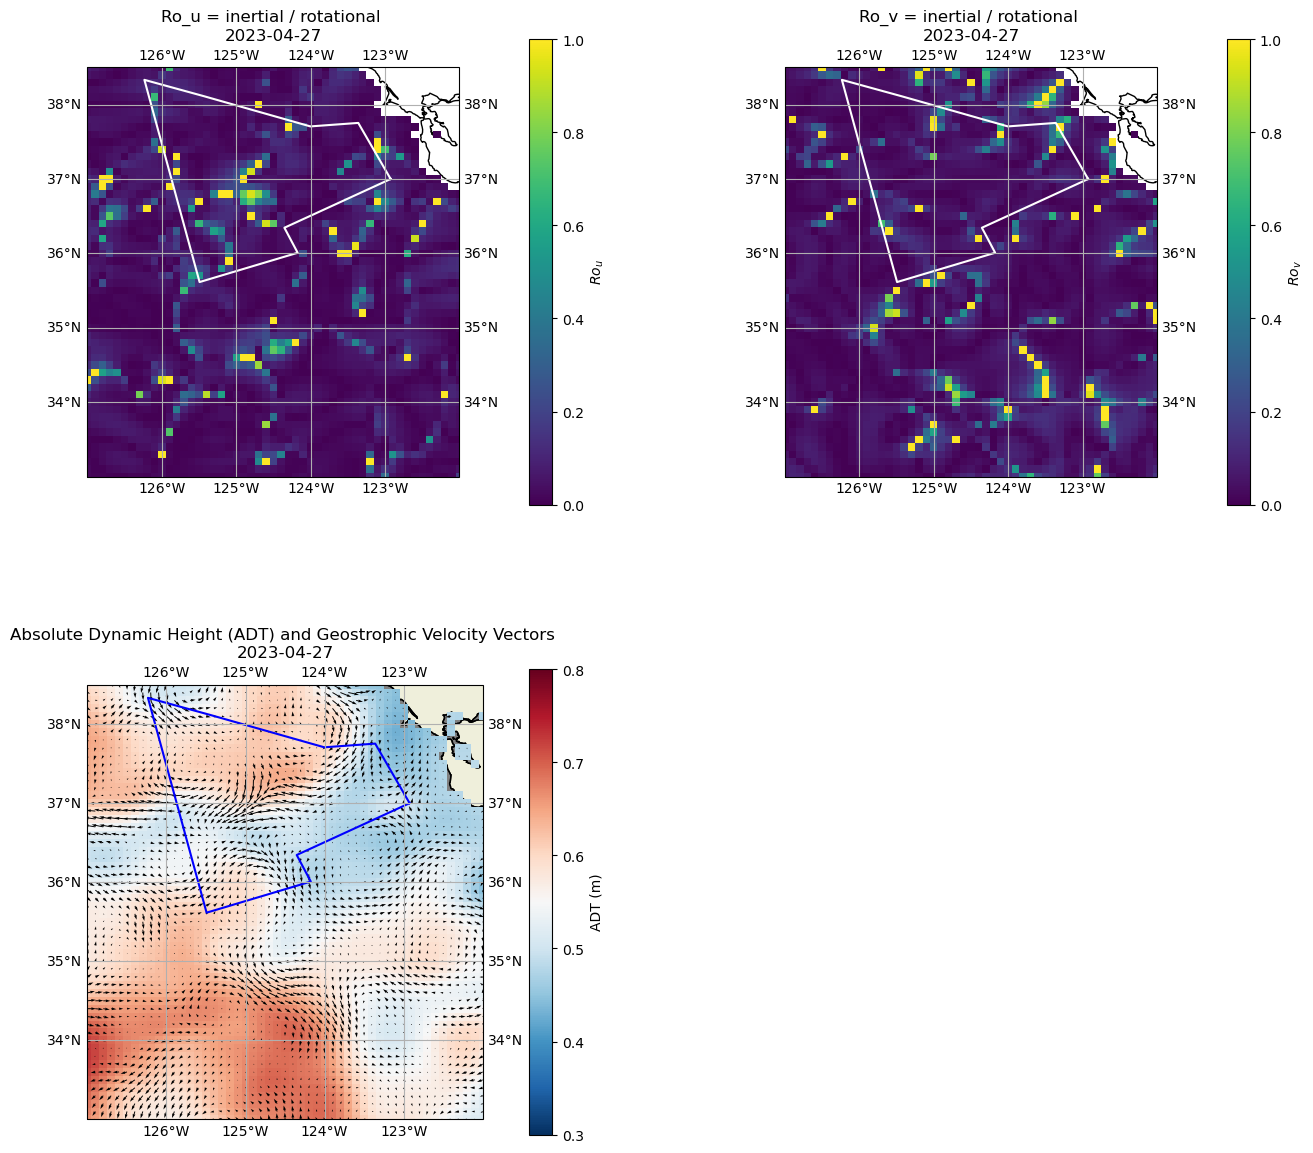

In [352]:
# Create the figure and axes
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()},
                              gridspec_kw={'wspace': 0.5})

ax1 = axs[0,0] #--------------------------------------------------------------------------------------------------
# Plot Ro_u
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
# Adding coastlines and gridlines
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.gridlines(draw_labels=True)

# Plot the polygon
ax1.plot(exterior_coords[0], exterior_coords[1], 'w-', transform=ccrs.PlateCarree())

# pcolormesh plot
pc1 = ax1.pcolormesh(lon, lat, u_Ro.isel(time=t_sel), vmin=0, vmax=1, cmap='viridis', transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(pc1, ax=ax1, orientation='vertical', label='$Ro_u$', pad=0.15, fraction=0.05)

# Title and labels
ax1.set_title(f'Ro_u = inertial / rotational \n{time_str}')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax2 = axs[0,1] #-----------------------------------------------------------------------------------------------------
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
# Plot Ro_v
# Adding coastlines and gridlines
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.gridlines(draw_labels=True)

# Plot the polygon
ax2.plot(exterior_coords[0], exterior_coords[1], 'w-', transform=ccrs.PlateCarree())

# pcolormesh plot
pc2 = ax2.pcolormesh(lon, lat, v_Ro.isel(time=t_sel), vmin=0, vmax=1, cmap='viridis', transform=ccrs.PlateCarree())
cbar2 = plt.colorbar(pc2, ax=ax2, orientation='vertical', label='$Ro_v$', pad=0.15, fraction=0.05)

# Title and labels
ax2.set_title(f'Ro_v = inertial / rotational \n{time_str}')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

ax3 = axs[1,0]  #--------------------------------------------------------------------------------------------
ax3.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
# Set the background color to gray
ax3.set_facecolor('gray')  # Plot background

# Set up the map features once (these won't change in the animation)
ax3.coastlines()
ax3.add_feature(cfeature.BORDERS, linestyle=':')
ax3.add_feature(cfeature.LAND, edgecolor='black')
ax3.gridlines(draw_labels=True)

# Plot the polygon
ax3.plot(exterior_coords[0], exterior_coords[1], 'b-', transform=ccrs.PlateCarree())

# Initialize the plots for updating
sla_plot = ax3.pcolormesh(lon, lat, adt.isel(time=t_sel), transform=ccrs.PlateCarree(), cmap='RdBu_r', shading='auto', vmin=0.3, vmax=.8)
# Create the colorbar
cbar3 = plt.colorbar(sla_plot, ax=ax3, orientation='vertical', label='ADT (m)', pad=0.1, fraction=0.05)

# Define scale for quiver arrows
scale = 10  # Adjust the scale factor to fit your data
# Create a quiver plot with initial data
quiver = ax3.quiver(lon, lat, ugos.isel(time=t_sel), vgos.isel(time=0), scale=scale, color='black', transform=ccrs.PlateCarree())

# Add a reference scale bar for quiver arrows
scale_length = 0.5  # Length of the scale bar in data units
ax3.quiverkey(quiver, X=0.75, Y=0.11, U=scale_length, label=f'{scale_length} m/s', labelpos='E', coordinates='figure', color='red')


# Set initial title
ax3.set_title(f'Absolute Dynamic Height (ADT) and Geostrophic Velocity Vectors \n{time_str}')

ax4 = axs[1,1]
ax4.set_visible(False)  # Hide the subplot

plt.show()